In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import functions

import glob
import pandas as pd
import re
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import matplotlib.colors as mcolors

import numpy as np

### df vs ff, daily vs once, langtang vs mustang -> 4 rows total 


In [2]:
# functions 

start_date = "1990-07-31"
end_date = "2021-06-30"


def filter_by_date(df, start_date = start_date, end_date = end_date, date_column='D'):
    """
    Filters a DataFrame to include only rows where the date_column is within the given range.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        start_date (str or pd.Timestamp): The start date (inclusive).
        end_date (str or pd.Timestamp): The end date (inclusive).
        date_column (str): The column containing date values (default is 'D').

    Returns:
        pd.DataFrame: The filtered DataFrame.
    """
    df[date_column] = pd.to_datetime(df[date_column])  # Convert to datetime
    return df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]


# Define a function to categorize seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'DJF'  # December, January, February (Winter)
    elif month in [3, 4, 5]:
        return 'MAM'  # March, April, May (Spring)
    elif month in [6, 7, 8]:
        return 'JJA'  # June, July, August (Summer)
    else:
        return 'SON'  # September, October, November (Autumn)

# Define a function to categorize seasons
def get_monsoon(month):
    if month in [1, 2, 3, 4]:
        return 'before monsoon'  
    elif month in [5, 6, 7, 8, 9]:
        return month  # should remain the same 
    elif month in [10, 11, 12]:
        return 'after monsoon'  # June, July, August (Summer)

def prepare_dfcount_for_plot(dfcount):
    melted = pd.melt(dfcount, id_vars=['D', 'D_year', 'D_month'], var_name='elevation', value_name='dfs_count')
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    melted = melted.sort_values('elevation_bin')
    # melted = melted.dropna(subset=['dfs_count'])
    return melted 


def prepare_dfcount_for_barplot(dfcount, landcover_idx):
    melted = pd.melt(dfcount, id_vars=['D', 'D_year', 'D_month'], var_name='elevation', value_name='dfs_count')
    melted['elevation'] = melted['elevation'].str.split('.').str[0].astype(float)
    melted['elevation_bin'] = melted.apply(functions.bin_elevation500, axis=1)
    melted = melted.sort_values('elevation_bin')
    melted['season'] = melted['D_month'].apply(get_season)
    melted['monsoon'] = melted['D_month'].apply(get_monsoon)

    melted['landcover'] = f'landcover {landcover_idx}'
    return melted 



def merge_landcover_dfs(dfs, dfspot, merge_on, dfspot_column):
    """
    Merges a list of dataframes on specified columns and adds a column from a 'dfspot' dataframe.
    
    Parameters:
        dfs (list of pd.DataFrame): List of dataframes to merge sequentially.
        dfspot (pd.DataFrame): A dataframe containing a column to add after the merges.
        merge_on (list of str): Columns to use as the merge keys.
        dfspot_column (str): The name of the column in `dfspot` to add after merging.
        
    Returns:
        pd.DataFrame: The merged dataframe with the additional column from `dfspot`.
    """
    
    # Start with the first dataframe in `dfs` and automatically get the count column
    count_column = [col for col in dfs[0].columns if col.startswith('dfs_count')][0]
    merged_df = dfs[0][merge_on + [count_column]]
    
    # Iterate over remaining dataframes and merge each sequentially
    for df in dfs[1:]:
        count_column = [col for col in df.columns if col.startswith('dfs_count')][0]
        merged_df = pd.merge(merged_df, df[merge_on + [count_column]], on=merge_on)
    
    # Add the `dfspot_column` from `dfspot` dataframe to the merged dataframe
    merged_df['dfspot_count'] = dfspot[dfspot_column]
    
    return merged_df


def calculate_floods(df):
    # df percent 
    df[f'dfs_count_60_percent'] = (df[f'dfs_count_60percent'] *100) / df.dfspot_count
    df[f'dfs_count_50_percent'] = (df[f'dfs_count_50percent'] *100) / df.dfspot_count
    df[f'dfs_count_40_percent'] = (df[f'dfs_count_40percent'] *100) / df.dfspot_count
    df[f'dfs_count_30_percent'] = (df[f'dfs_count_30percent'] *100) / df.dfspot_count
    df[f'dfs_count_20_percent'] = (df[f'dfs_count_20percent'] *100) / df.dfspot_count
    # ff count 
    df[f'ffs_count_60'] = df.dfspot_count - df[f'dfs_count_60percent']
    df[f'ffs_count_50'] = df.dfspot_count - df[f'dfs_count_50percent']
    df[f'ffs_count_40'] = df.dfspot_count - df[f'dfs_count_40percent']
    df[f'ffs_count_30'] = df.dfspot_count - df[f'dfs_count_30percent']
    df[f'ffs_count_20'] = df.dfspot_count - df[f'dfs_count_20percent']
    # ff percent
    df[f'ffs_count_60_percent'] = (df[f'ffs_count_60'] *100) / df.dfspot_count
    df[f'ffs_count_50_percent'] = (df[f'ffs_count_50'] *100) / df.dfspot_count
    df[f'ffs_count_40_percent'] = (df[f'ffs_count_40'] *100) / df.dfspot_count
    df[f'ffs_count_30_percent'] = (df[f'ffs_count_30'] *100) / df.dfspot_count
    df[f'ffs_count_20_percent'] = (df[f'ffs_count_20'] *100) / df.dfspot_count
    return df



In [3]:
# dfspot3_df

# plots with bubbles 

In [4]:
# read those files 
outpath = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025May_output/df_vs_floods/'

landcover1O = pd.read_csv(outpath + 'langtang_df_vs_floods_once_landcover1.csv', index_col=0)
landcover2O = pd.read_csv(outpath + 'langtang_df_vs_floods_once_landcover2.csv', index_col=0)
landcover3O = pd.read_csv(outpath + 'langtang_df_vs_floods_once_landcover3.csv', index_col=0)
landcover4O = pd.read_csv(outpath + 'langtang_df_vs_floods_once_landcover4.csv', index_col=0)
landcover5O = pd.read_csv(outpath + 'langtang_df_vs_floods_once_landcover5.csv', index_col=0)


landcover1D = pd.read_csv(outpath + 'langtang_df_vs_floods_daily_landcover1.csv', index_col=0)
landcover2D = pd.read_csv(outpath + 'langtang_df_vs_floods_daily_landcover2.csv', index_col=0)
landcover3D = pd.read_csv(outpath + 'langtang_df_vs_floods_daily_landcover3.csv', index_col=0)
landcover4D = pd.read_csv(outpath + 'langtang_df_vs_floods_daily_landcover4.csv', index_col=0)
landcover5D = pd.read_csv(outpath + 'langtang_df_vs_floods_daily_landcover5.csv', index_col=0)


In [5]:
landcover1O

,year,month,elevation,elevation_bin,id,dfs_count_30percent,dfs_count_20percent,dfs_count_60percent,dfs_count_40percent,dfs_count_50percent,...,ffs_count_60,ffs_count_50,ffs_count_40,ffs_count_30,ffs_count_20,ffs_count_60_percent,ffs_count_50_percent,ffs_count_40_percent,ffs_count_30_percent,ffs_count_20_percent
0,1989,9,4485,4000 - 4500,4485_1989_9,0,0,0,0,0,...,1,1,1,1,1,100.0,100.0,100.0,100.0,100.0
1,1989,10,4485,4000 - 4500,4485_1989_10,0,0,0,0,0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2,1989,11,4485,4000 - 4500,4485_1989_11,0,0,0,0,0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
3,1989,12,4485,4000 - 4500,4485_1989_12,0,0,0,0,0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
4,1990,1,4485,4000 - 4500,4485_1990_1,0,0,0,0,0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20639,2022,5,5936,5500 - 6000,5936_2022_5,0,0,0,0,0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
20640,2022,6,5936,5500 - 6000,5936_2022_6,0,0,0,0,0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
20641,2022,7,5936,5500 - 6000,5936_2022_7,0,0,0,0,0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
20642,2022,8,5936,5500 - 6000,5936_2022_8,0,0,0,0,0,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN


In [6]:
# # check the "empty" elevation bins without any DFs potentially 

# dfs = {"df1": landcover1, "df2": landcover2, "df3": landcover3, "df4": landcover4, "df5": landcover5}  # Example dictionary of dataframes

# empty_bins_per_df = {}

# for name, df in dfs.items():
#     # empty_bins = df.groupby("elevation_bin")["dfspot_count"].apply(lambda x: (x.isna() | (x == 0)).all())
#     empty_bins = df.groupby("elevation_bin")["dfspot_count"].apply(lambda x: (x.isna()).all())
#     empty_bins_per_df[name] = empty_bins[empty_bins].index.tolist()

# # Print results
# for name, empty_bins in empty_bins_per_df.items():
#     print(f"Elevation bins with only 0/NaN dfspot in {name}: {empty_bins}")


In [7]:
# def monthly_mean_per_elevation(df):
#     mean = df.groupby(['elevation_bin', 'month']).mean().reset_index() 
#     return mean
    
def monthly_mean(df):
    mean = df.groupby(['month']).mean().reset_index() 
    return mean


# landcover1monthly_comb = monthly_mean(landcover1)
# landcover2monthly_comb = monthly_mean(landcover2)
# landcover3monthly_comb = monthly_mean(landcover3)
# landcover4monthly_comb = monthly_mean(landcover4)
# landcover5monthly_comb = monthly_mean(landcover5)


landcover1monthlyO = monthly_mean(landcover1O)
landcover2monthlyO = monthly_mean(landcover2O)
landcover3monthlyO = monthly_mean(landcover3O)
landcover4monthlyO = monthly_mean(landcover4O)
landcover5monthlyO = monthly_mean(landcover5O)

landcover1monthlyO['landcover']='landcover 1'
landcover2monthlyO['landcover']='landcover 2'
landcover3monthlyO['landcover']='landcover 3'
landcover4monthlyO['landcover']='landcover 4'
landcover5monthlyO['landcover']='landcover 5'

landcover1monthlyD = monthly_mean(landcover1D)
landcover2monthlyD = monthly_mean(landcover2D)
landcover3monthlyD = monthly_mean(landcover3D)
landcover4monthlyD = monthly_mean(landcover4D)
landcover5monthlyD = monthly_mean(landcover5D)


landcover1monthlyD['landcover']='landcover 1'
landcover2monthlyD['landcover']='landcover 2'
landcover3monthlyD['landcover']='landcover 3'
landcover4monthlyD['landcover']='landcover 4'
landcover5monthlyD['landcover']='landcover 5'

landcover_all_month_daily = pd.concat([landcover1monthlyD, landcover2monthlyD, landcover3monthlyD, 
                                       landcover4monthlyD, landcover5monthlyD])

landcover_all_month_once = pd.concat([landcover1monthlyO, landcover2monthlyO, landcover3monthlyO, 
                                      landcover4monthlyO, landcover5monthlyO])

In [8]:
testdaily1= landcover_all_month_daily[landcover_all_month_daily['landcover'].str.strip() == 'landcover 1']
testonce1= landcover_all_month_once[landcover_all_month_once['landcover'].str.strip() ==    'landcover 1']


In [9]:
testdaily1

,month,year,elevation,dfs_count_30percent,dfs_count_20percent,dfs_count_60percent,dfs_count_40percent,dfs_count_50percent,dfspot_count,dfs_count_60_percent,...,ffs_count_50,ffs_count_40,ffs_count_30,ffs_count_20,ffs_count_60_percent,ffs_count_50_percent,ffs_count_40_percent,ffs_count_30_percent,ffs_count_20_percent,landcover
0,1,2006.0,4822.576923,0.002331,0.002331,0.002331,0.002331,0.002331,0.002331,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,landcover 1
1,2,2006.0,4822.576923,0.005828,0.005828,0.005828,0.005828,0.005828,0.005828,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,landcover 1
2,3,2006.0,4822.576923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,landcover 1
3,4,2006.0,4822.576923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,landcover 1
4,5,2006.0,4822.576923,0.062354,0.062354,0.062354,0.062354,0.062354,0.062354,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,landcover 1
5,6,2006.0,4822.576923,0.674825,0.655012,0.696970,0.686480,0.694639,0.696970,100.000000,...,0.002331,0.010490,0.022145,0.041958,0.000000,0.103126,0.533446,1.447777,3.378536,landcover 1
6,7,2006.0,4822.576923,2.227273,1.870629,2.664918,2.453963,2.601981,2.675408,99.105307,...,0.073427,0.221445,0.448135,0.804779,0.894693,3.708069,8.135903,15.038779,24.980687,landcover 1
7,8,2006.0,4822.576923,1.469114,1.129953,2.107226,1.749417,1.977855,2.179487,95.275953,...,0.201632,0.430070,0.710373,1.049534,4.724047,10.355424,18.970844,28.824809,43.170309,landcover 1
8,9,2005.5,4822.576923,0.448529,0.360294,0.645362,0.510747,0.601244,0.684955,93.299595,...,0.083710,0.174208,0.236425,0.324661,6.700405,12.227363,20.912698,27.979243,41.266949,landcover 1
9,10,2005.0,4822.576923,0.053030,0.048368,0.059441,0.055361,0.056527,0.062354,94.696970,...,0.005828,0.006993,0.009324,0.013986,5.303030,9.848485,11.363636,13.888889,21.464646,landcover 1


<AxesSubplot:label='E', xlabel='month', ylabel='dfs_count_60_percent'>

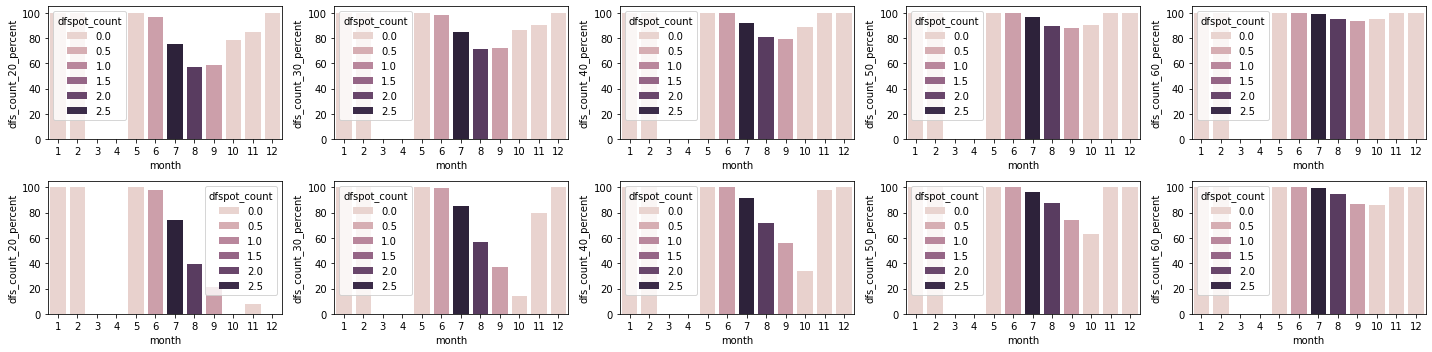

In [10]:
fig = plt.figure(figsize=(20, 5), layout='tight')
mosaic = fig.subplot_mosaic('''
                            abcde
                            ABCDE
                            ''')


sns.barplot(data = testdaily1, y = 'dfs_count_20_percent', x='month', ax = mosaic['a'], hue = 'dfspot_count')
sns.barplot(data = testdaily1, y = 'dfs_count_30_percent', x='month', ax = mosaic['b'], hue = 'dfspot_count')#, hue = 'elevation_bin',, legend = False)
sns.barplot(data = testdaily1, y = 'dfs_count_40_percent', x='month', ax = mosaic['c'], hue = 'dfspot_count')#, hue = 'elevation_bin',, legend = False)
sns.barplot(data = testdaily1, y = 'dfs_count_50_percent', x='month', ax = mosaic['d'], hue = 'dfspot_count')
sns.barplot(data = testdaily1, y = 'dfs_count_60_percent', x='month', ax = mosaic['e'], hue = 'dfspot_count')

sns.barplot(data = testonce1, y = 'dfs_count_20_percent', x='month', ax = mosaic['A'], hue = 'dfspot_count')
sns.barplot(data = testonce1, y = 'dfs_count_30_percent', x='month', ax = mosaic['B'], hue = 'dfspot_count')#, hue = 'elevation_bin',, legend = False)
sns.barplot(data = testonce1, y = 'dfs_count_40_percent', x='month', ax = mosaic['C'], hue = 'dfspot_count')#, hue = 'elevation_bin',, legend = False)
sns.barplot(data = testonce1, y = 'dfs_count_50_percent', x='month', ax = mosaic['D'], hue = 'dfspot_count')
sns.barplot(data = testonce1, y = 'dfs_count_60_percent', x='month', ax = mosaic['E'], hue = 'dfspot_count')


In [11]:
# landcover_all_month_daily.columns
# which columns do i care about?

# ffs_count_60_percent
# dfs_count_60_percent
# dfspot_count

'''
'dfspot_count', 
'dfs_count_60_percent',
'dfs_count_50_percent', 
'dfs_count_40_percent', 
'dfs_count_30_percent',
'dfs_count_20_percent', 
'ffs_count_60_percent',
'ffs_count_50_percent', 
'ffs_count_40_percent', 
'ffs_count_30_percent',
'ffs_count_20_percent', 
'landcover'
'''
# landcover_all_month_daily

"\n'dfspot_count', \n'dfs_count_60_percent',\n'dfs_count_50_percent', \n'dfs_count_40_percent', \n'dfs_count_30_percent',\n'dfs_count_20_percent', \n'ffs_count_60_percent',\n'ffs_count_50_percent', \n'ffs_count_40_percent', \n'ffs_count_30_percent',\n'ffs_count_20_percent', \n'landcover'\n"

In [12]:
daily20 = landcover_all_month_daily[['dfs_count_20_percent','ffs_count_20_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]
daily30 = landcover_all_month_daily[['dfs_count_30_percent','ffs_count_30_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]
daily40 = landcover_all_month_daily[['dfs_count_40_percent','ffs_count_40_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]
daily50 = landcover_all_month_daily[['dfs_count_50_percent','ffs_count_50_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]
daily60 = landcover_all_month_daily[['dfs_count_60_percent','ffs_count_60_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]

once20 = landcover_all_month_once[['dfs_count_20_percent','ffs_count_20_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]
once30 = landcover_all_month_once[['dfs_count_30_percent','ffs_count_30_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]
once40 = landcover_all_month_once[['dfs_count_40_percent','ffs_count_40_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]
once50 = landcover_all_month_once[['dfs_count_50_percent','ffs_count_50_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]
once60 = landcover_all_month_once[['dfs_count_60_percent','ffs_count_60_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]


In [13]:
import pandas as pd

# Define a function to rename columns
def rename_and_add_column(df, percentile):
    df = df.rename(columns={
        df.columns[0]: 'dfs_count_percent',  # Renaming first column
        df.columns[1]: 'ffs_count_percent'   # Renaming second column
    })
    df['percentile_input'] = f'{percentile} percent'
    return df

# Rename and add column for each dataframe
daily20 = rename_and_add_column(daily20, 20)
daily30 = rename_and_add_column(daily30, 30)
daily40 = rename_and_add_column(daily40, 40)
daily50 = rename_and_add_column(daily50, 50)
daily60 = rename_and_add_column(daily60, 60)

# Concatenate all dataframes
df_daily = pd.concat([daily20, daily30, daily40, daily50, daily60], ignore_index=True)

df_daily1= df_daily[df_daily.landcover =='landcover 1']
df_daily2= df_daily[df_daily.landcover =='landcover 2']
df_daily3= df_daily[df_daily.landcover =='landcover 3']
df_daily4= df_daily[df_daily.landcover =='landcover 4']
df_daily5= df_daily[df_daily.landcover =='landcover 5']


# Rename and add column for each dataframe
once20 = rename_and_add_column(once20, 20)
once30 = rename_and_add_column(once30, 30)
once40 = rename_and_add_column(once40, 40)
once50 = rename_and_add_column(once50, 50)
once60 = rename_and_add_column(once60, 60)

# Concatenate all dataframes
df_once = pd.concat([once20, once30, once40, once50, once60], ignore_index=True)

df_once1= df_once[df_once.landcover =='landcover 1']
df_once2= df_once[df_once.landcover =='landcover 2']
df_once3= df_once[df_once.landcover =='landcover 3']
df_once4= df_once[df_once.landcover =='landcover 4']
df_once5= df_once[df_once.landcover =='landcover 5']




# final plot for langtang! 

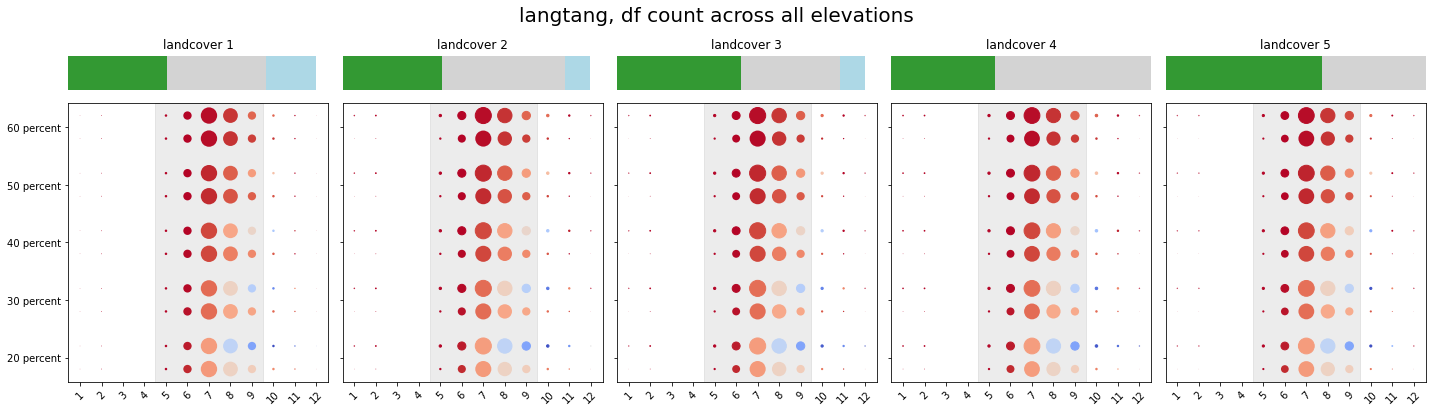

In [14]:
vmin = 0
vmax = 100
center = vmax/2
# Convert categorical landcover to numeric for plotting
percentile_numeric, percentile_labels = pd.factorize(df_once1.percentile_input)

# # Define normalization with midpoint at 50%
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)



fig = plt.figure(figsize=(20, 5.8), layout='tight')
mosaic = fig.subplot_mosaic('''
                            ABCDE
                            abcde
                            abcde
                            abcde
                            abcde
                            abcde
                            abcde
                            ''')

# List of subplot keys where the grey background should be applied
target_axes = ['a', 'b', 'c', 'd', 'e']

# Apply axvspan **only to the target axes**
for key in target_axes:
    mosaic[key].axvspan(5 - 0.5, 9 + 0.5, color='grey', alpha=0.15)

s1 = mosaic['a'].scatter(x = df_daily1.month, y = percentile_numeric-0.20, c = df_daily1.dfs_count_percent, s = df_daily1.dfspot_count*100, cmap = 'coolwarm', norm=norm, edgecolor = 'none')
mosaic['a'].scatter(x = df_once1.month, y = percentile_numeric+0.20, c = df_once1.dfs_count_percent, s = df_once1.dfspot_count*100, cmap = 'coolwarm', norm=norm, edgecolor = 'none')

mosaic['b'].scatter(x = df_daily2.month, y = percentile_numeric-0.20, c = df_daily2.dfs_count_percent, s = df_daily2.dfspot_count*100, cmap = 'coolwarm', norm=norm,  edgecolor = 'none')
mosaic['b'].scatter(x = df_once2.month,  y = percentile_numeric+0.20,  c = df_once2.dfs_count_percent,  s = df_once2.dfspot_count*100, cmap = 'coolwarm', norm=norm)

mosaic['c'].scatter(x = df_daily3.month, y = percentile_numeric-0.20, c = df_daily3.dfs_count_percent, s = df_daily3.dfspot_count*100, cmap = 'coolwarm', norm=norm,  edgecolor = 'none')
mosaic['c'].scatter(x = df_once3.month,  y = percentile_numeric+0.20,  c = df_once3.dfs_count_percent,  s = df_once3.dfspot_count*100, cmap = 'coolwarm', norm=norm)

mosaic['d'].scatter(x = df_daily4.month, y = percentile_numeric-0.20, c = df_daily4.dfs_count_percent, s = df_daily4.dfspot_count*100, cmap = 'coolwarm', norm=norm,  edgecolor = 'none')
mosaic['d'].scatter(x = df_once4.month,  y = percentile_numeric+0.20,  c = df_once4.dfs_count_percent,  s = df_once4.dfspot_count*100, cmap = 'coolwarm', norm=norm)


mosaic['e'].scatter(x = df_daily5.month, y = percentile_numeric-0.20, c = df_daily5.dfs_count_percent, s = df_daily5.dfspot_count*100, cmap = 'coolwarm', norm=norm,  edgecolor = 'none')
mosaic['e'].scatter(x = df_once5.month,  y = percentile_numeric+0.20,  c = df_once5.dfs_count_percent,  s = df_once5.dfspot_count*100, cmap = 'coolwarm', norm=norm)


mosaic['a'].set_yticks(range(len(percentile_labels)))
mosaic['a'].set_yticklabels(percentile_labels)



# cbar1 = fig.colorbar(s1, ax=mosaic['e'], orientation='vertical', fraction=0.1, pad=0.1)


# -------------------

for key in ['a', 'b', 'c', 'd', 'e']:
    mosaic[key].set_xticks(df_once1.month.unique())  # Set tick positions
    mosaic[key].set_xticklabels(df_once1.month.unique(), rotation=45)  # Set tick labels, rotate

for key in ['a']:
    mosaic[key].set_yticks(range(len(percentile_labels)))
    mosaic[key].set_yticklabels(percentile_labels)

for key in ['b', 'c', 'd', 'e']:
    mosaic[key].set_yticklabels([])


mosaic['A'].set_title('landcover 1')
mosaic['B'].set_title('landcover 2')
mosaic['C'].set_title('landcover 3')
mosaic['D'].set_title('landcover 4')
mosaic['E'].set_title('landcover 5')


# plt.savefig(outpath + 'bubble_plot_landcover_panels_new_legend.png', dpi = 300, bbox_inches = 'tight')
plt.suptitle('langtang, df count across all elevations', fontsize = 20)


# color bar for land cover shares 

# Define color proportions for each panel (Green, Yellow, Gray)
shares = [
    (40, 40, 20),  # First bar: 40% green (veg) , 30% grey (bedrock), 30% blue (glacier)
    (40, 50, 10),
    (50, 40, 10),
    (40, 60, 00),
    (60, 40, 00),
]

# Iterate over the bar row and create the proportional bars
for i, key in enumerate("ABCDE"):
    bar_ax = mosaic[key]  # Select the correct subplot for the bar

    # Remove ticks, labels, and spines
    bar_ax.set_xticks([])
    bar_ax.set_yticks([])
    bar_ax.set_frame_on(False)

    # Extract proportions (must sum to 100%)
    p1, p2, p3 = shares[i]  # Green, Yellow, Gray

    # Convert percentages to width (normalized to 1)
    p1 /= 100
    p2 /= 100
    p3 /= 100

    # Plot the three segments
    bar_ax.barh(0, p1, height=1, color='green', align='center', alpha = 0.8)
    bar_ax.barh(0, p2, height=1, color='lightgray', left=p1, align='center')
    bar_ax.barh(0, p3, height=1, color='lightblue', left=p1 + p2, align='center')

    # # Add percentage label (can be adjusted)
    # bar_ax.text(0.5, 0, f"{shares[i][0]}% / {shares[i][1]}% / {shares[i][2]}%", 
    #             ha='center', va='center', fontsize=12, color='black', weight='bold')


# plt.savefig('/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/output/testplots/bubble_plot_landcover_panels_new_legend.png', bbox_inches = 'tight', dpi = 300)





In [15]:
outpath

'/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025May_output/df_vs_floods/'

In [16]:
# df_daily1

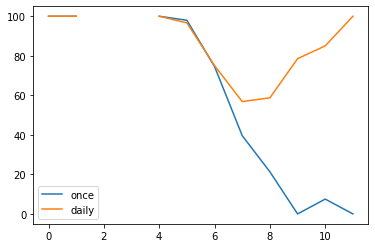

In [17]:
df_once1[df_once1['percentile_input'] =='20 percent'].dfs_count_percent.plot(label = 'once')
df_daily1[df_daily1['percentile_input'] =='20 percent'].dfs_count_percent.plot(label = 'daily')
plt.legend()

<AxesSubplot:>

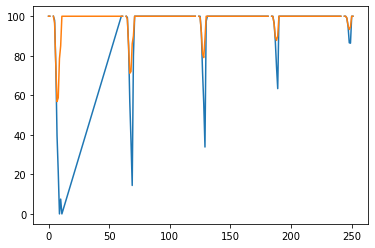

In [18]:
df_once1.dfs_count_percent.plot()
df_daily1.dfs_count_percent.plot()

<AxesSubplot:>

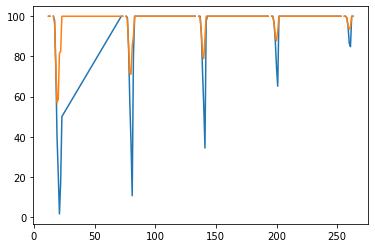

In [19]:
df_once2.dfs_count_percent.plot()
df_daily2.dfs_count_percent.plot()

# mustang

In [20]:
# read those files 
outpath = '/Users/varyabazilova/Desktop/paper2/202406_modelruns/30years/2025May_output/df_vs_floods/'

landcover1Om = pd.read_csv(outpath + 'mustang_df_vs_floods_once_landcover1.csv', index_col=0)
landcover2Om = pd.read_csv(outpath + 'mustang_df_vs_floods_once_landcover2.csv', index_col=0)
landcover3Om = pd.read_csv(outpath + 'mustang_df_vs_floods_once_landcover3.csv', index_col=0)
landcover4Om = pd.read_csv(outpath + 'mustang_df_vs_floods_once_landcover4.csv', index_col=0)
landcover5Om = pd.read_csv(outpath + 'mustang_df_vs_floods_once_landcover5.csv', index_col=0)


landcover1Dm = pd.read_csv(outpath + 'mustang_df_vs_floods_daily_landcover1.csv', index_col=0)
landcover2Dm = pd.read_csv(outpath + 'mustang_df_vs_floods_daily_landcover2.csv', index_col=0)
landcover3Dm = pd.read_csv(outpath + 'mustang_df_vs_floods_daily_landcover3.csv', index_col=0)
landcover4Dm = pd.read_csv(outpath + 'mustang_df_vs_floods_daily_landcover4.csv', index_col=0)
landcover5Dm = pd.read_csv(outpath + 'mustang_df_vs_floods_daily_landcover5.csv', index_col=0)


In [21]:

landcover1monthlyOm = monthly_mean(landcover1Om)
landcover2monthlyOm = monthly_mean(landcover2Om)
landcover3monthlyOm = monthly_mean(landcover3Om)
landcover4monthlyOm = monthly_mean(landcover4Om)
landcover5monthlyOm = monthly_mean(landcover5Om)

landcover1monthlyOm['landcover']='landcover 1'
landcover2monthlyOm['landcover']='landcover 2'
landcover3monthlyOm['landcover']='landcover 3'
landcover4monthlyOm['landcover']='landcover 4'
landcover5monthlyOm['landcover']='landcover 5'

landcover1monthlyDm = monthly_mean(landcover1Dm)
landcover2monthlyDm = monthly_mean(landcover2Dm)
landcover3monthlyDm = monthly_mean(landcover3Dm)
landcover4monthlyDm = monthly_mean(landcover4Dm)
landcover5monthlyDm = monthly_mean(landcover5Dm)


landcover1monthlyDm['landcover']='landcover 1'
landcover2monthlyDm['landcover']='landcover 2'
landcover3monthlyDm['landcover']='landcover 3'
landcover4monthlyDm['landcover']='landcover 4'
landcover5monthlyDm['landcover']='landcover 5'

landcover_all_month_daily_m = pd.concat([landcover1monthlyDm, landcover2monthlyDm, landcover3monthlyDm, 
                                       landcover4monthlyDm, landcover5monthlyDm])

landcover_all_month_once_m = pd.concat([landcover1monthlyOm, landcover2monthlyOm, landcover3monthlyOm, 
                                      landcover4monthlyOm, landcover5monthlyOm])

In [22]:
daily20m = landcover_all_month_daily_m[['dfs_count_20_percent','ffs_count_20_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]
daily30m = landcover_all_month_daily_m[['dfs_count_30_percent','ffs_count_30_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]
daily40m = landcover_all_month_daily_m[['dfs_count_40_percent','ffs_count_40_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]
daily50m = landcover_all_month_daily_m[['dfs_count_50_percent','ffs_count_50_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]
daily60m = landcover_all_month_daily_m[['dfs_count_60_percent','ffs_count_60_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]

once20m = landcover_all_month_once_m[['dfs_count_20_percent','ffs_count_20_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]
once30m = landcover_all_month_once_m[['dfs_count_30_percent','ffs_count_30_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]
once40m = landcover_all_month_once_m[['dfs_count_40_percent','ffs_count_40_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]
once50m = landcover_all_month_once_m[['dfs_count_50_percent','ffs_count_50_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]
once60m = landcover_all_month_once_m[['dfs_count_60_percent','ffs_count_60_percent', 'dfspot_count', 'landcover', 'month','year',	'elevation']]


In [23]:
import pandas as pd

# Define a function to rename columns
def rename_and_add_column(df, percentile):
    df = df.rename(columns={
        df.columns[0]: 'dfs_count_percent',  # Renaming first column
        df.columns[1]: 'ffs_count_percent'   # Renaming second column
    })
    df['percentile_input'] = f'{percentile} percent'
    return df

# Rename and add column for each dataframe
daily20m = rename_and_add_column(daily20m, 20)
daily30m = rename_and_add_column(daily30m, 30)
daily40m = rename_and_add_column(daily40m, 40)
daily50m = rename_and_add_column(daily50m, 50)
daily60m = rename_and_add_column(daily60m, 60)

# Concatenate all dataframes
df_daily_m = pd.concat([daily20m, daily30m, daily40m, daily50m, daily60m], ignore_index=True)

df_daily1m= df_daily_m[df_daily_m.landcover =='landcover 1']
df_daily2m= df_daily_m[df_daily_m.landcover =='landcover 2']
df_daily3m= df_daily_m[df_daily_m.landcover =='landcover 3']
df_daily4m= df_daily_m[df_daily_m.landcover =='landcover 4']
df_daily5m= df_daily_m[df_daily_m.landcover =='landcover 5']


# Rename and add column for each dataframe
once20m = rename_and_add_column(once20m, 20)
once30m = rename_and_add_column(once30m, 30)
once40m = rename_and_add_column(once40m, 40)
once50m = rename_and_add_column(once50m, 50)
once60m = rename_and_add_column(once60m, 60)

# Concatenate all dataframes
df_once_m = pd.concat([once20m, once30m, once40m, once50m, once60m], ignore_index=True)

df_once1m= df_once_m[df_once_m.landcover =='landcover 1']
df_once2m= df_once_m[df_once_m.landcover =='landcover 2']
df_once3m= df_once_m[df_once_m.landcover =='landcover 3']
df_once4m= df_once_m[df_once_m.landcover =='landcover 4']
df_once5m= df_once_m[df_once_m.landcover =='landcover 5']



In [24]:
percentile_labels_plot = pd.factorize(df_once1m.percentile_input)
percentile_numeric

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

[]

<Figure size 432x288 with 0 Axes>

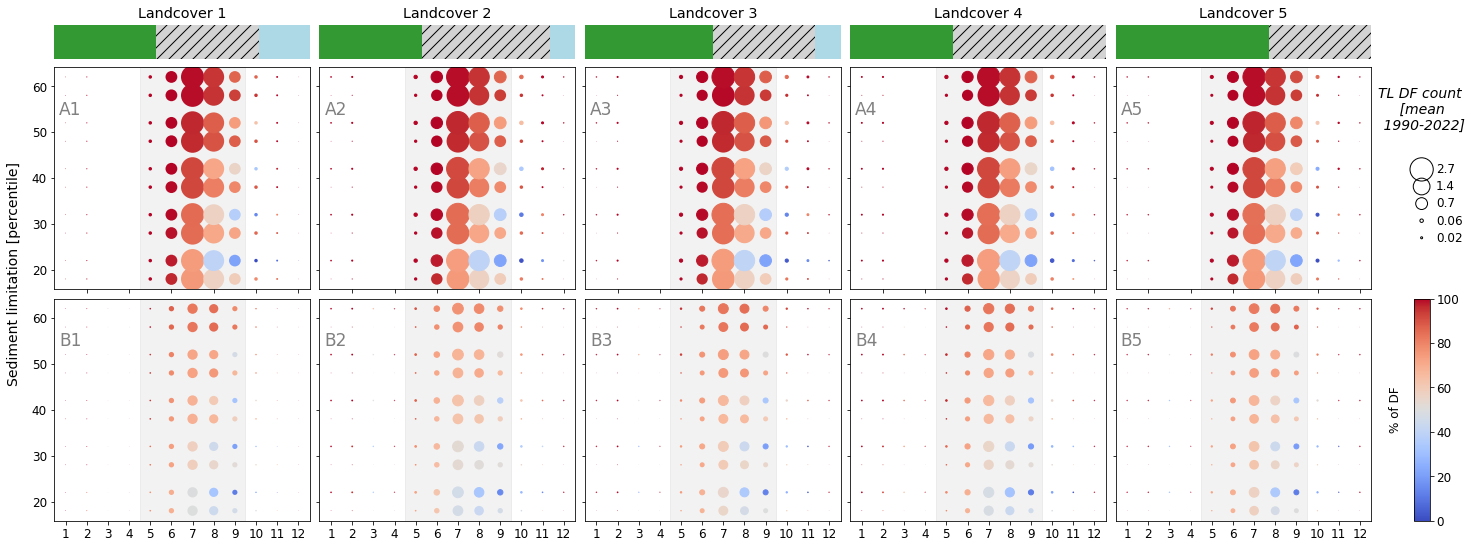

In [25]:
vmin = 0
vmax = 100
center = vmax/2

plt.rcParams.update({'font.size': 12})


# Convert categorical landcover to numeric for plotting
percentile_numeric, percentile_labels = pd.factorize(df_once1m.percentile_input)
numeric_labels = [int(label.replace(" percent", "")) for label in percentile_labels]



# # Define normalization with midpoint at 50%
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)

plt.subplots_adjust(hspace=0, wspace=0)  # Reduce spacing between subplots


fig = plt.figure(figsize=(20, 7.5), layout='constrained')
mosaic = fig.subplot_mosaic('''
                            kkkkkkkkllllllllmmmmmmmmnnnnnnnnoooooooop
                            AAAAAAAABBBBBBBBCCCCCCCCDDDDDDDDEEEEEEEEj
                            AAAAAAAABBBBBBBBCCCCCCCCDDDDDDDDEEEEEEEEj
                            AAAAAAAABBBBBBBBCCCCCCCCDDDDDDDDEEEEEEEEj
                            AAAAAAAABBBBBBBBCCCCCCCCDDDDDDDDEEEEEEEEj
                            AAAAAAAABBBBBBBBCCCCCCCCDDDDDDDDEEEEEEEEj
                            AAAAAAAABBBBBBBBCCCCCCCCDDDDDDDDEEEEEEEEj
                            aaaaaaaabbbbbbbbccccccccddddddddeeeeeeeei
                            aaaaaaaabbbbbbbbccccccccddddddddeeeeeeeei
                            aaaaaaaabbbbbbbbccccccccddddddddeeeeeeeei
                            aaaaaaaabbbbbbbbccccccccddddddddeeeeeeeei
                            aaaaaaaabbbbbbbbccccccccddddddddeeeeeeeei
                            aaaaaaaabbbbbbbbccccccccddddddddeeeeeeeei
                            ''')



# THIS IS GREY MONSOON BACKGROUND PART

# List of subplot keys where the grey background should be applied
target_axes = ['a', 'b', 'c', 'd', 'e','A', 'B', 'C', 'D', 'E']

# Apply axvspan **only to the target axes**
for key in target_axes:
    mosaic[key].axvspan(5 - 0.5, 9 + 0.5, color='grey', alpha=0.1)



# THIS IS LANGTANG PART # 

s1 = mosaic['A'].scatter(x = df_daily1.month, y = percentile_numeric-0.20, c = df_daily1.dfs_count_percent, s = df_daily1.dfspot_count*200, cmap = 'coolwarm', norm=norm, edgecolor = 'none')
mosaic['A'].scatter(x = df_once1.month, y = percentile_numeric+0.20, c = df_once1.dfs_count_percent, s = df_once1.dfspot_count*200, cmap = 'coolwarm', norm=norm, edgecolor = 'none')

mosaic['B'].scatter(x = df_daily2.month, y = percentile_numeric-0.20, c = df_daily2.dfs_count_percent, s = df_daily2.dfspot_count*200, cmap = 'coolwarm', norm=norm,  edgecolor = 'none')
mosaic['B'].scatter(x = df_once2.month,  y = percentile_numeric+0.20,  c = df_once2.dfs_count_percent,  s = df_once2.dfspot_count*200, cmap = 'coolwarm', norm=norm)

mosaic['C'].scatter(x = df_daily3.month, y = percentile_numeric-0.20, c = df_daily3.dfs_count_percent, s = df_daily3.dfspot_count*200, cmap = 'coolwarm', norm=norm,  edgecolor = 'none')
mosaic['C'].scatter(x = df_once3.month,  y = percentile_numeric+0.20,  c = df_once3.dfs_count_percent,  s = df_once3.dfspot_count*200, cmap = 'coolwarm', norm=norm)

mosaic['D'].scatter(x = df_daily4.month, y = percentile_numeric-0.20, c = df_daily4.dfs_count_percent, s = df_daily4.dfspot_count*200, cmap = 'coolwarm', norm=norm,  edgecolor = 'none')
mosaic['D'].scatter(x = df_once4.month,  y = percentile_numeric+0.20,  c = df_once4.dfs_count_percent,  s = df_once4.dfspot_count*200, cmap = 'coolwarm', norm=norm)


mosaic['E'].scatter(x = df_daily5.month, y = percentile_numeric-0.20, c = df_daily5.dfs_count_percent, s = df_daily5.dfspot_count*200, cmap = 'coolwarm', norm=norm,  edgecolor = 'none')
mosaic['E'].scatter(x = df_once5.month,  y = percentile_numeric+0.20,  c = df_once5.dfs_count_percent,  s = df_once5.dfspot_count*200, cmap = 'coolwarm', norm=norm)


mosaic['A'].set_yticks(range(len(percentile_labels)))
mosaic['A'].set_yticklabels(percentile_labels)


# THIS IS MUSTANG PART

s1 = mosaic['a'].scatter(x = df_daily1m.month, y = percentile_numeric-0.20, c = df_daily1m.dfs_count_percent, s = df_daily1m.dfspot_count*200, cmap = 'coolwarm', norm=norm, edgecolor = 'none')
mosaic['a'].scatter(x = df_once1m.month, y = percentile_numeric+0.20, c = df_once1m.dfs_count_percent, s = df_once1m.dfspot_count*200, cmap = 'coolwarm', norm=norm, edgecolor = 'none')

mosaic['b'].scatter(x = df_daily2m.month, y = percentile_numeric-0.20, c = df_daily2m.dfs_count_percent, s = df_daily2m.dfspot_count*200, cmap = 'coolwarm', norm=norm,  edgecolor = 'none')
mosaic['b'].scatter(x =  df_once2m.month, y = percentile_numeric+0.20,  c = df_once2m.dfs_count_percent,  s = df_once2m.dfspot_count*200, cmap = 'coolwarm', norm=norm)

mosaic['c'].scatter(x = df_daily3m.month, y = percentile_numeric-0.20, c = df_daily3m.dfs_count_percent, s = df_daily3m.dfspot_count*200, cmap = 'coolwarm', norm=norm,  edgecolor = 'none')
mosaic['c'].scatter(x =  df_once3m.month,  y = percentile_numeric+0.20, c = df_once3m.dfs_count_percent,  s = df_once3m.dfspot_count*200, cmap = 'coolwarm', norm=norm)

mosaic['d'].scatter(x = df_daily4m.month, y = percentile_numeric-0.20, c = df_daily4m.dfs_count_percent, s = df_daily4m.dfspot_count*200, cmap = 'coolwarm', norm=norm,  edgecolor = 'none')
mosaic['d'].scatter(x =  df_once4m.month,  y = percentile_numeric+0.20, c = df_once4m.dfs_count_percent,  s = df_once4m.dfspot_count*200, cmap = 'coolwarm', norm=norm)


mosaic['e'].scatter(x = df_daily5m.month, y = percentile_numeric-0.20, c = df_daily5m.dfs_count_percent, s = df_daily5m.dfspot_count*200, cmap = 'coolwarm', norm=norm,  edgecolor = 'none')
mosaic['e'].scatter(x = df_once5m.month,  y = percentile_numeric+0.20,  c = df_once5m.dfs_count_percent,  s = df_once5m.dfspot_count*200, cmap = 'coolwarm', norm=norm)


mosaic['a'].set_yticks(range(len(percentile_labels)))
mosaic['a'].set_yticklabels(percentile_labels)


# THIS IS AXIS PART 

for key in ['a', 'b', 'c', 'd', 'e']:
    mosaic[key].set_xticks(df_once1.month.unique())  # Set tick positions
    mosaic[key].set_xticklabels(df_once1.month.unique())#, rotation=45)  # Set tick labels, rotate

for key in ['a']:
    mosaic[key].set_yticks(range(len(percentile_labels)))
    # mosaic[key].set_yticklabels(percentile_labels)
    mosaic[key].set_yticklabels(numeric_labels)

for key in ['A']:
    mosaic[key].set_yticks(range(len(percentile_labels)))
    # mosaic[key].set_yticklabels(percentile_labels)
    mosaic[key].set_yticklabels(numeric_labels)

for key in ['b', 'c', 'd', 'e', 'B', 'C', 'D', 'E']:
    mosaic[key].set_yticklabels([])

for key in ['A', 'B', 'C', 'D', 'E']:
    mosaic[key].set_xticklabels([])


fig.text(
    x=-0.015,              # x-position in figure 
    y=0.5,               # y-position (centered vertically)
    s="Sediment limitation [percentile]",   # your label text
    va='center',         # vertical alignment
    rotation='vertical', # rotate to be vertical
    fontsize=14          # or whatever you like
)






mosaic['k'].set_title('Landcover 1')
mosaic['l'].set_title('Landcover 2')
mosaic['m'].set_title('Landcover 3')
mosaic['n'].set_title('Landcover 4')
mosaic['o'].set_title('Landcover 5')



# THIS IS LANDCOVER PART


# color bar for land cover shares 

# Define color proportions for each panel (Green, Yellow, Gray)
shares = [
    (40, 40, 20),  # First bar: 40% green (veg) , 30% grey (bedrock), 30% blue (glacier)
    (40, 50, 10),
    (50, 40, 10),
    (40, 60, 00),
    (60, 40, 00),
]

# Iterate over the bar row and create the proportional bars
for i, key in enumerate("klmno"):
    bar_ax = mosaic[key]  # Select the correct subplot for the bar

    # Remove ticks, labels, and spines
    bar_ax.set_xticks([])
    bar_ax.set_yticks([])
    bar_ax.set_frame_on(False)

    # Extract proportions (must sum to 100%)
    p1, p2, p3 = shares[i]  # Green, Yellow, Gray

    # Convert percentages to width (normalized to 1)
    p1 /= 100
    p2 /= 100
    p3 /= 100

    # Plot the three segments
    bar_ax.barh(0, p1, height=4, color='green', align='center', alpha=0.8)
    bar_ax.barh(0, p2, height=4, color='lightgray', left=p1, align='center', hatch = '//')
    bar_ax.barh(0, p3, height=4, color='lightblue', left=p1 + p2, align='center')
    bar_ax.set_xlim(0, 1)





# Define labels for ABCDE and abcde panels
labels = {
    "A": "A1", "B": "A2", "C": "A3", "D": "A4", "E": "A5",
    "a": "B1", "b": "B2", "c": "B3", "d": "B4", "e": "B5"
}

# Iterate over only the panels that need labels
for key, ax in mosaic.items():
    if key in labels:  # Only label the specified panels
        ax.text(0.02, 0.85, labels[key], transform=ax.transAxes, 
                ha='left', va='top', fontsize=17, color = 'grey')






# LEGEND THINGS 

fig.patch.set_facecolor('xkcd:white')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# # Create an inset axis inside panel 'd' with better positioning
cax = inset_axes(mosaic['i'], width="50%", height="100%", loc='center')

# Create the colorbar

cmap = plt.cm.coolwarm

cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), 
                     cax=cax, orientation='vertical')

mosaic['i'].set_facecolor('none')  # Make the background transparent

mosaic['i'].spines['top'].set_visible(False)
mosaic['i'].spines['right'].set_visible(False)
mosaic['i'].spines['bottom'].set_visible(False)
mosaic['i'].spines['left'].set_visible(False)
mosaic['i'].set_xticklabels([])
mosaic['i'].set_yticklabels([])
mosaic['i'].set_yticks([])
mosaic['i'].set_xticks([])
mosaic['i'].set_ylabel('% of DF')


mosaic['p'].set_facecolor('none')  # Make the background transparent
mosaic['p'].spines['top'].set_visible(False)
mosaic['p'].spines['right'].set_visible(False)
mosaic['p'].spines['bottom'].set_visible(False)
mosaic['p'].spines['left'].set_visible(False)
mosaic['p'].set_xticklabels([])
mosaic['p'].set_yticklabels([])
mosaic['p'].set_yticks([])
mosaic['p'].set_xticks([])


# LEGEND BUBBLES 
bubbles = pd.DataFrame({'value':[ 0.02, 0.06, 0.7, 1.4, 2.7]})
bubbles['xposition'] = 2
bubles = bubbles.reset_index()

mosaic['j'].scatter(x = bubbles.xposition, y = bubbles.index, s = bubbles.value*200, color = 'none', edgecolor = 'black')
mosaic['j'].set_ylim(-3, 10)

# Add labels to the bubbles
for i, row in bubbles.iterrows():
    mosaic['j'].text(row['xposition'] + 0.1, row.name, str(row['value']), ha='left', va='center')
    # values = [2.7, 2.2, 0.7, 0.06, 0.02, 0.006]

mosaic['j'].text(2, 7.5,  'TL DF count \n [mean \n 1990-2022]', ha='center', va='center', fontsize=14, fontstyle = 'italic')


mosaic['j'].spines['top'].set_visible(False)
mosaic['j'].spines['right'].set_visible(False)
mosaic['j'].spines['bottom'].set_visible(False)
mosaic['j'].spines['left'].set_visible(False)
mosaic['j'].set_xticklabels([])
mosaic['j'].set_yticklabels([])
mosaic['j'].set_yticks([])
mosaic['j'].set_xticks([])



# plt.savefig('/Users/varyabazilova/Desktop/paper2/plots_experiments/landcover_df_vs_ff_bubbles_all.png', bbox_inches = 'tight', dpi = 300)

In [26]:
df_daily1[:12].dfspot_count.mean()

0.5324583504730563

In [27]:
df_daily1[:12].dfspot_count.values


array([2.33100233e-03, 5.82750583e-03, 0.00000000e+00, 0.00000000e+00,
       6.23543124e-02, 6.96969697e-01, 2.67540793e+00, 2.17948718e+00,
       6.84954751e-01, 6.23543124e-02, 1.86480186e-02, 1.16550117e-03])

In [28]:
values = [2.33100233e-03, 5.82750583e-03, 0.00000000e+00, 0.00000000e+00,
       6.23543124e-02, 6.96969697e-01, 2.67540793e+00, 2.17948718e+00,
       6.84954751e-01, 6.23543124e-02, 1.86480186e-02, 1.16550117e-03]

# Convert to DataFrame
df = pd.DataFrame({'Value': values})

# Get evenly spaced quantiles
quantiles = df['Value'].quantile([0, 0.25, 0.5, 0.75, 1]).round().astype(float)

# Create DataFrame for selected values
df_selected = pd.DataFrame({'Selected Values': quantiles.values})
df_selected

,Selected Values
0,0.0
1,0.0
2,0.0
3,1.0
4,3.0


In [29]:
# df.sort_values('Value')
# df_selected

In [30]:
df['number'] = np.linspace(0, len(df), num = len(df))

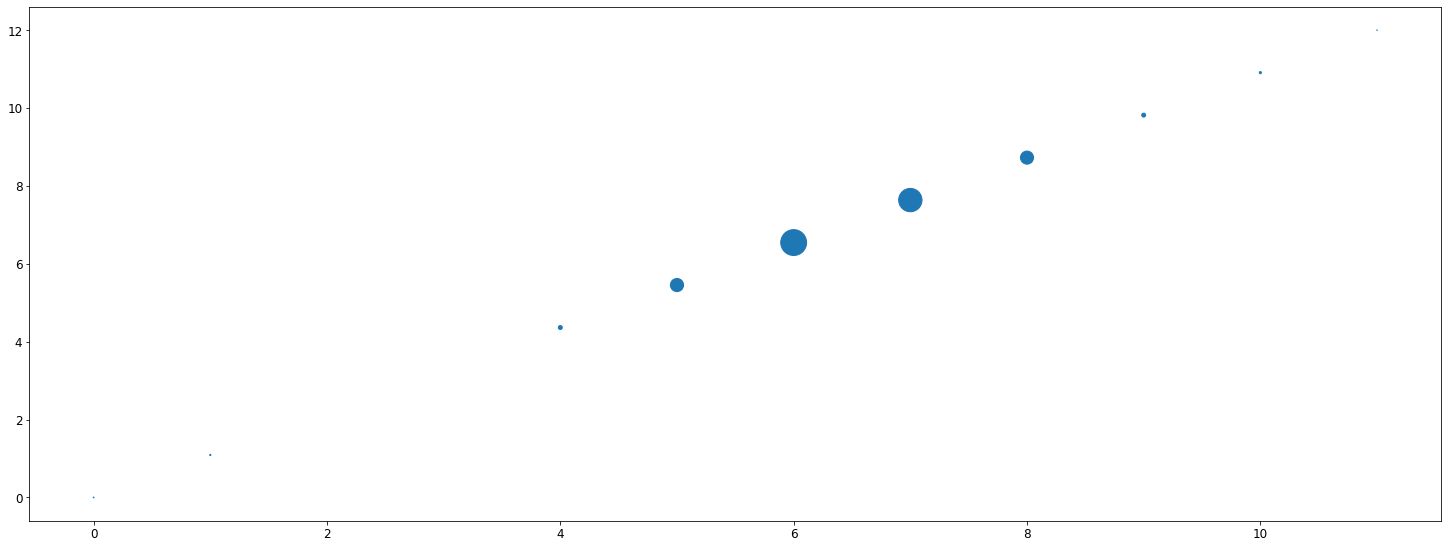

In [31]:
fig = plt.figure(figsize=(20, 7.5), layout='constrained')

plt.scatter(x = df.index, y = df.number, s = df.Value*250)

In [32]:
df

,Value,number
0,0.002331,0.000000
1,0.005828,1.090909
2,0.000000,2.181818
3,0.000000,3.272727
4,0.062354,4.363636
5,0.696970,5.454545
6,2.675408,6.545455
7,2.179487,7.636364
8,0.684955,8.727273
9,0.062354,9.818182


In [33]:
values = [2.33100233e-03, 5.82750583e-03, 0.00000000e+00, 0.00000000e+00,
       6.23543124e-02, 6.96969697e-01, 2.67540793e+00, 2.17948718e+00,
       6.84954751e-01, 6.23543124e-02, 1.86480186e-02, 1.16550117e-03,
       2.33100233e-03, 5.82750583e-03, 0.00000000e+00, 0.00000000e+00,
       6.23543124e-02, 6.96969697e-01, 2.67540793e+00, 2.17948718e+00,
       6.84954751e-01, 6.23543124e-02, 1.86480186e-02, 1.16550117e-03,
       2.33100233e-03, 5.82750583e-03, 0.00000000e+00, 0.00000000e+00,
       6.23543124e-02, 6.96969697e-01, 2.67540793e+00, 2.17948718e+00,
       6.84954751e-01, 6.23543124e-02, 1.86480186e-02, 1.16550117e-03,
       2.33100233e-03, 5.82750583e-03, 0.00000000e+00, 0.00000000e+00,
       6.23543124e-02, 6.96969697e-01, 2.67540793e+00, 2.17948718e+00,
       6.84954751e-01, 6.23543124e-02, 1.86480186e-02, 1.16550117e-03,
       2.33100233e-03, 5.82750583e-03, 0.00000000e+00, 0.00000000e+00,
       6.23543124e-02, 6.96969697e-01, 2.67540793e+00, 2.17948718e+00,
       6.84954751e-01, 6.23543124e-02, 1.86480186e-02, 1.16550117e-03]

In [34]:
values

[0.00233100233,
 0.00582750583,
 0.0,
 0.0,
 0.0623543124,
 0.696969697,
 2.67540793,
 2.17948718,
 0.684954751,
 0.0623543124,
 0.0186480186,
 0.00116550117,
 0.00233100233,
 0.00582750583,
 0.0,
 0.0,
 0.0623543124,
 0.696969697,
 2.67540793,
 2.17948718,
 0.684954751,
 0.0623543124,
 0.0186480186,
 0.00116550117,
 0.00233100233,
 0.00582750583,
 0.0,
 0.0,
 0.0623543124,
 0.696969697,
 2.67540793,
 2.17948718,
 0.684954751,
 0.0623543124,
 0.0186480186,
 0.00116550117,
 0.00233100233,
 0.00582750583,
 0.0,
 0.0,
 0.0623543124,
 0.696969697,
 2.67540793,
 2.17948718,
 0.684954751,
 0.0623543124,
 0.0186480186,
 0.00116550117,
 0.00233100233,
 0.00582750583,
 0.0,
 0.0,
 0.0623543124,
 0.696969697,
 2.67540793,
 2.17948718,
 0.684954751,
 0.0623543124,
 0.0186480186,
 0.00116550117]

# plot volume instead of dfspot counts per month 